In [1]:
!python -V

Python 3.9.25


In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [18]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp1/02-experiment-tracking/mlruns/1', creation_time=1762894451969, experiment_id='1', last_update_time=1762894451969, lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [6]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829626

/tmp/ipykernel_13787/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_13787/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


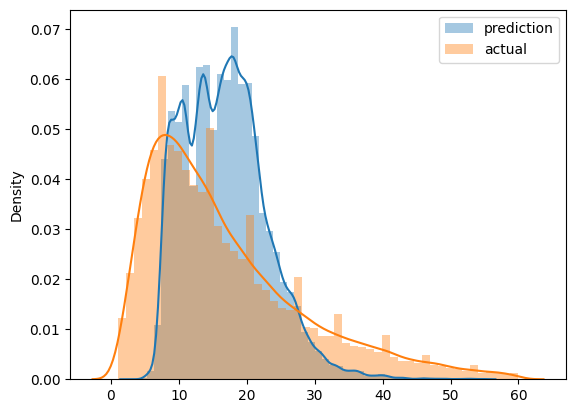

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715208009878

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer", "al")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [ ]:
################################

In [19]:
import xgboost as xgb
#import mlflow
#import mlflow.xgboost
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:

from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
import numpy as np



train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


# -----------------------------
# Define objective function
# -----------------------------
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
            verbose_eval=True,
        )

        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)

        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}


# -----------------------------
# Define search space
# -----------------------------
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "gamma": hp.uniform("gamma", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 10),
    "reg_lambda": hp.uniform("reg_lambda", 0, 10),
    "min_child_weight": hp.uniform("min_child_weight", 0, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "objective": "reg:linear",
    "seed": 42,
}


# -----------------------------
# Run optimization
# -----------------------------
mlflow.set_experiment("xgboost-hyperopt")

trials = Trials()

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
)

print("\nBest hyperparameters:")
print(best_result)



[0]	validation-rmse:11.86891                             
[1]	validation-rmse:11.54403                             
  0%|             | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.23910                             
[3]	validation-rmse:11.22204                             
[4]	validation-rmse:10.93595                             
[5]	validation-rmse:10.66645                             
[6]	validation-rmse:10.41481                             
[7]	validation-rmse:10.17762                             
[8]	validation-rmse:9.95372                              
[9]	validation-rmse:9.74319                              
[10]	validation-rmse:9.54644                             
[11]	validation-rmse:9.36187                             
[12]	validation-rmse:9.18983                             
[13]	validation-rmse:9.02717                             
[14]	validation-rmse:8.87605                             
[15]	validation-rmse:8.73499                             
[16]	validation-rmse:8.60333                             
[17]	validation-rmse:8.48033                             
[18]	validation-rmse:8.36601                             
[19]	validatio

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:12.02269                             
[2]	validation-rmse:11.92986                             
[3]	validation-rmse:11.92287                             
[4]	validation-rmse:11.83175                             
[5]	validation-rmse:11.74197                             
[6]	validation-rmse:11.65368                             
[7]	validation-rmse:11.56658                             
[8]	validation-rmse:11.48083                             
[9]	validation-rmse:11.39618                             
[10]	validation-rmse:11.31338                            
[11]	validation-rmse:11.30928                            
[12]	validation-rmse:11.30220                            
[13]	validation-rmse:11.22054                            
[14]	validation-rmse:11.14030                            
[15]	validation-rmse:11.06111                            
[16]	validation-rmse:10.98339                            
[17]	validation-rmse:10.90669                            
[18]	validatio

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:50:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.59577                             
[3]	validation-rmse:11.58507                             
[4]	validation-rmse:11.39489                             
[5]	validation-rmse:11.21088                             
[6]	validation-rmse:11.03427                             
[7]	validation-rmse:10.86320                             
[8]	validation-rmse:10.69873                             
[9]	validation-rmse:10.54009                             
[10]	validation-rmse:10.38718                            
[11]	validation-rmse:10.38063                            
[12]	validation-rmse:10.37085                            
[13]	validation-rmse:10.22363                            
[14]	validation-rmse:10.08258                            
[15]	validation-rmse:9.94636                             
[16]	validation-rmse:9.81545                             
[17]	validation-rmse:9.68938                             
[18]	validation-rmse:9.56860                             
[19]	validatio

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:51:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.85019                             
[2]	validation-rmse:11.67704                             
[3]	validation-rmse:11.66434                             
[4]	validation-rmse:11.49742                             
[5]	validation-rmse:11.33551                             
[6]	validation-rmse:11.17833                             
[7]	validation-rmse:11.02536                             
[8]	validation-rmse:10.87771                             
[9]	validation-rmse:10.73454                             
[10]	validation-rmse:10.59562                            
[11]	validation-rmse:10.59056                            
[12]	validation-rmse:10.57907                            
[13]	validation-rmse:10.44509                            
[14]	validation-rmse:10.31503                            
[15]	validation-rmse:10.18889                            
[16]	validation-rmse:10.06734                            
[17]	validation-rmse:9.94937                             
[18]	validatio

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:53:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:12.03036                             
[2]	validation-rmse:11.94109                             
[3]	validation-rmse:11.93185                             
[4]	validation-rmse:11.84394                             
[5]	validation-rmse:11.75735                             
[6]	validation-rmse:11.67224                             
[7]	validation-rmse:11.58841                             
[8]	validation-rmse:11.50575                             
[9]	validation-rmse:11.42440                             
[10]	validation-rmse:11.34409                            
[11]	validation-rmse:11.26518                            
[12]	validation-rmse:11.18733                            
[13]	validation-rmse:11.11082                            
[14]	validation-rmse:11.03533                            
[15]	validation-rmse:10.96113                            
[16]	validation-rmse:10.88811                            
[17]	validation-rmse:10.81619                            
[18]	validatio

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:55:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.88234                             
[3]	validation-rmse:11.87498                             
[4]	validation-rmse:11.76932                             
[5]	validation-rmse:11.66507                             
[6]	validation-rmse:11.56333                             
[7]	validation-rmse:11.46330                             
[8]	validation-rmse:11.36483                             
[9]	validation-rmse:11.26798                             
[10]	validation-rmse:11.17364                            
[11]	validation-rmse:11.08078                            
[12]	validation-rmse:10.98978                            
[13]	validation-rmse:10.90016                            
[14]	validation-rmse:10.81270                            
[15]	validation-rmse:10.72663                            
[16]	validation-rmse:10.64230                            
[17]	validation-rmse:10.55928                            
[18]	validation-rmse:10.47834                            
[19]	validatio